In [7]:
import paho.mqtt.client as mqtt
import joblib
import numpy as np
import pandas as pd
from adaptive_agent import MultiAnomalyAgent
import csv
import os
from datetime import datetime
import requests  # For pushing to Power BI

# 🔁 Load scaler and models
scaler = joblib.load("saved_models_temperature_only/scaler.pkl")
logistic = joblib.load("saved_models_temperature_only/logistic_regression.pkl")
rf = joblib.load("saved_models_temperature_only/random_forest.pkl")
xgb = joblib.load("saved_models_temperature_only/xgboost.pkl")
iso = joblib.load("saved_models_temperature_only/isolation_forest.pkl")
ocsvm = joblib.load("saved_models_temperature_only/one_class_svm.pkl")

# 🧠 Initialize RL Agent
agent = MultiAnomalyAgent()

# 📊 History for Z-Score
history = []

# 📝 CSV setup
csv_file = "anomaly_logs.csv"
if not os.path.exists(csv_file):
    with open(csv_file, mode="w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["timestamp", "temperature", "z_score", "z_status", "majority_anomaly", "normal_temperature", "anomaly_temperature"])

# 🌐 MQTT Setup
BROKER = "localhost"
PORT = 1883
TOPIC = "home/temperature"

# 🔗 Power BI API URL
POWER_BI_API_URL = "https://api.powerbi.com/beta/d02378ec-1688-46d5-8540-1c28b5f470f6/datasets/781f46b3-8877-4aea-9d78-bab1d915abaa/rows?language=en-US&disableBranding=1&experience=power-bi&key=bqDxT%2FsDt6JL3NDFFrNAK5nVVot02yC5pBPoPsZyIDxIHNWOye15MXsD2O53Z46ZgriwXZUzC80fasqy%2B%2BsJPQ%3D%3D"

def on_message(client, userdata, msg):
    try:
        temp = float(msg.payload.decode())
        print(f"\n📉 Received => Temp: {temp:.2f}")
        history.append(temp)

        # ⚡ Z-Score
        z_score = 0
        z_status = "Not enough data"
        if len(history) >= 5:
            hist_mean = np.mean(history)
            hist_std = np.std(history)
            z_score = (temp - hist_mean) / hist_std if hist_std != 0 else 0
            z_status = "Anomaly" if abs(z_score) > 2 else "Normal"
            print(f"⚡ Z-Score Based: {z_status} (z={z_score:.2f})")
        else:
            print("⚡ Z-Score Based: Not enough data yet")

        # 🧪 Prepare
        X = pd.DataFrame([[temp]], columns=["Temperature"])
        X_scaled = scaler.transform(X)

        # 🤖 Model Predictions
        print("🧠 Model Decisions:")
        decisions = []

        logistic_pred = int(logistic.predict(X_scaled)[0] == 1)
        decisions.append(logistic_pred)
        print(f"  Logistic Regression: {'Anomaly' if logistic_pred else 'Normal'}")

        rf_proba = rf.predict_proba(X_scaled)[0][1]
        rf_pred = int(rf_proba > 0.6)
        decisions.append(rf_pred)
        print(f"  Random Forest: {'Anomaly' if rf_pred else 'Normal'} (p={rf_proba:.2f})")

        xgb_proba = xgb.predict_proba(X_scaled)[0][1]
        xgb_pred = int(xgb_proba > 0.6)
        decisions.append(xgb_pred)
        print(f"  XGBoost: {'Anomaly' if xgb_pred else 'Normal'} (p={xgb_proba:.2f})")

        iso_pred = int(iso.predict(X_scaled)[0] == -1)
        decisions.append(iso_pred)
        print(f"  Isolation Forest: {'Anomaly' if iso_pred else 'Normal'}")

        ocsvm_pred = int(ocsvm.predict(X_scaled)[0] == -1)
        decisions.append(ocsvm_pred)
        print(f"  One-Class SVM: {'Anomaly' if ocsvm_pred else 'Normal'}")

        # 📊 Majority Voting
        majority_anomaly = int(sum(decisions) > len(decisions) / 2)
        print(f"🗳️ Majority Vote: {'Anomaly' if majority_anomaly else 'Normal'}")

        # 🧠 RL Agent
        agent_decision = agent.decide(temp)
        print(f"🧠 RL Agent: {'Anomaly' if agent_decision else 'Normal'}")
        print(f"📈 RL Agent Spike Thresh: {agent.spike_threshold:.2f} | Drop Thresh: {agent.drop_threshold:.2f}")
        agent.update(temp, decisions, agent_decision)

        # ✅ Separate normal and anomaly for Power BI
        anomaly_temp = temp if majority_anomaly == 1 else None
        normal_temp = temp if majority_anomaly == 0 else None

        # 💾 Save to CSV
        with open(csv_file, mode="a", newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                temp,
                round(z_score, 2),
                z_status,
                majority_anomaly,
                normal_temp,
                anomaly_temp
            ])

        # 📤 Push to Power BI
        payload = [{
            "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "z_score": round(z_score, 2),
            "majority_anomaly": majority_anomaly,
            "normal_temperature": float(normal_temp) if normal_temp is not None else None,
            "anomaly_temperature": float(anomaly_temp) if anomaly_temp is not None else None,
        }]
        response = requests.post(POWER_BI_API_URL, json=payload)

        if response.status_code == 200:
            print("🚀 Data pushed to Power BI successfully.")
        else:
            print(f"⚠️ Failed to push to Power BI: {response.status_code} {response.text}")

    except Exception as e:
        print("⚠️ Error:", e)

# 📡 MQTT connection
client = mqtt.Client()
client.connect(BROKER, PORT, 60)
client.subscribe(TOPIC)
client.on_message = on_message

print("📡 Listening for temperature data...")
client.loop_forever()

C:\Users\PC\AppData\Local\Temp\ipykernel_15004\4125585358.py:134: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client()


📡 Listening for temperature data...

📉 Received => Temp: 22.62
⚡ Z-Score Based: Not enough data yet
🧠 Model Decisions:
  Logistic Regression: Normal
  Random Forest: Normal (p=0.00)
  XGBoost: Normal (p=0.02)
  Isolation Forest: Normal
  One-Class SVM: Normal
🗳️ Majority Vote: Normal
🧠 RL Agent: Normal
📈 RL Agent Spike Thresh: 10.00 | Drop Thresh: -10.00
🚀 Data pushed to Power BI successfully.

📉 Received => Temp: 22.61
⚡ Z-Score Based: Not enough data yet
🧠 Model Decisions:
  Logistic Regression: Normal
  Random Forest: Normal (p=0.00)
  XGBoost: Normal (p=0.02)
  Isolation Forest: Normal
  One-Class SVM: Normal
🗳️ Majority Vote: Normal
🧠 RL Agent: Normal
📈 RL Agent Spike Thresh: 10.00 | Drop Thresh: -10.00
🚀 Data pushed to Power BI successfully.

📉 Received => Temp: 11.10
⚡ Z-Score Based: Not enough data yet
🧠 Model Decisions:
  Logistic Regression: Anomaly
  Random Forest: Anomaly (p=1.00)
  XGBoost: Anomaly (p=0.99)
  Isolation Forest: Anomaly
  One-Class SVM: Normal
🗳️ Majority Vo

KeyboardInterrupt: 

In [3]:
import pandas as pd

# Load the CSV log
df = pd.read_csv("anomaly_logs.csv")

# Display basic info
print("📊 Logged Entries:", len(df))
print("🧪 Sample Data:")
display(df.tail())

# Optional: Convert timestamp to datetime if needed
df['timestamp'] = pd.to_datetime(df['timestamp'])

ParserError: Error tokenizing data. C error: Expected 5 fields in line 78, saw 6


In [5]:
import matplotlib.pyplot as plt

# Split anomalies vs normal based on majority vote
anomalies = df[df['majority_anomaly'] == 1]
normal = df[df['majority_anomaly'] == 0]

plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['temperature'], label="Temperature", marker='o', color='skyblue')
plt.scatter(anomalies['timestamp'], anomalies['temperature'], color='red', label='Detected Anomaly', zorder=5)

plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("🌡️ Temperature Readings with Detected Anomalies (Majority Vote)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

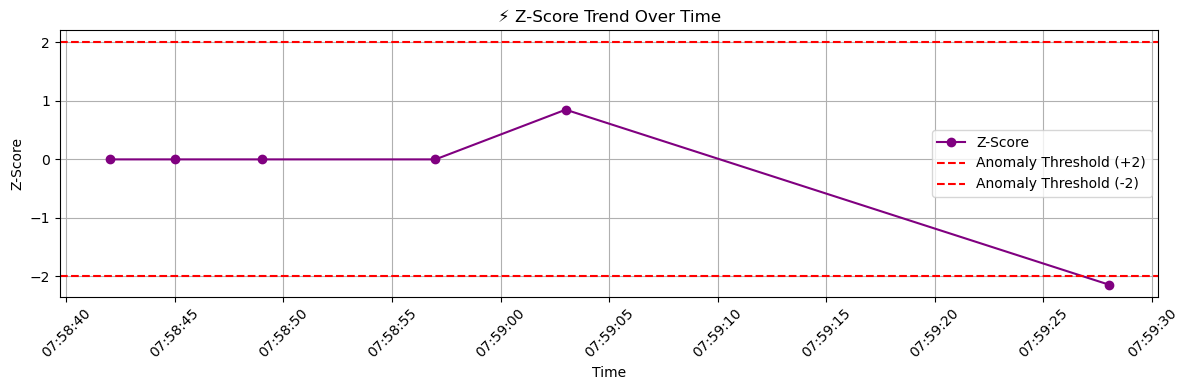

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(df['timestamp'], df['z_score'], label="Z-Score", color='purple', marker='o')
plt.axhline(2, color='red', linestyle='--', label='Anomaly Threshold (+2)')
plt.axhline(-2, color='red', linestyle='--', label='Anomaly Threshold (-2)')

plt.xlabel("Time")
plt.ylabel("Z-Score")
plt.title("⚡ Z-Score Trend Over Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()